<a href="https://colab.research.google.com/github/balakhnyov/technoatom-ML-homeworks/blob/main/homework2/hw_unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="images/header.png" width=400></center>

<h1><center>Основы машинного обучения</center></h1>
<hr>
<h2><center>Методы обучения без учителя: Домашняя работа</center></h2>

Правила:

* Отчеты принимаются до 23:59 11 апреля. Вы должны залить ваш ноутбук в [colab](https://colab.research.google.com) и дать на него ссылку в форме сдачи ДЗ на портале
* Работоспособность будет проверяться в коллабе. Это значит что:
    1. Вам надо удостовериться, что код отрабатывает от начала и до конца. Выполните аналог "Restart Kernel and Run All" в colab
    2. Убедитесь, что данные автоматически подгружается с помощью команды `!wget` (см семинары для примера). Все нужные данные есть [здесь](https://github.com/vadim0912/MLbase_2021_spring/tree/master/lecture04/data)
    3. Все необходимые модули тоже устанавливаются на лету через `!pip`


In [ ]:
%matplotlib inline

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-talk')
plt.rcParams['figure.figsize'] = (15,10)

# Задача про датчики на руках

В этом задании мы применим метод главных компонент на многомерных данных и постараемся найти оптимальную размерность признаков для решения задачи классификации

Исходными [данными](http://archive.ics.uci.edu/ml/machine-learning-databases/auslan2-mld/auslan.data.html) являются показания различных сенсоров, установленных на руках человека, который умеет общаться на языке жестов.

В данном случае задача ставится следующим образом: по показаниям датчиков (по 11 сенсоров на каждую руку) определить слово, которое было показано человеком.

Как можно решать такую задачу?

Показания датчиков представляются в виде временных рядов. Посмотрим на показания для одного из "слов"

In [ ]:
# Uncomment if you are using colab
!mkdir ./data
!wget https://raw.githubusercontent.com/vadim0912/MLbase_2021_spring/l4/lecture04/data/winequality-red.csv -O ./data/winequality-red.csv
!wget https://raw.githubusercontent.com/vadim0912/MLbase_2021_spring/l4/lecture04/data/sign_database.csv -O ./data/sign_database.csv
!wget https://raw.githubusercontent.com/vadim0912/MLbase_2021_spring/l4/lecture04/data/sign_classes.csv -O ./data/sign_classes.csv

--2021-04-11 01:42:52--  https://raw.githubusercontent.com/vadim0912/MLbase_2021_spring/l4/lecture04/data/winequality-red.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84199 (82K) [text/plain]
Saving to: ‘./data/winequality-red.csv’

./data/winequality- 100%[===================>]  82.23K  --.-KB/s    in 0.01s   

2021-04-11 01:42:52 (6.41 MB/s) - ‘./data/winequality-red.csv’ saved [84199/84199]

--2021-04-11 01:42:52--  https://raw.githubusercontent.com/vadim0912/MLbase_2021_spring/l4/lecture04/data/sign_database.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request s

In [ ]:
# Загружаем данные сенсоров
df_database = pd.read_csv('./data/sign_database.csv')

# Загружаем метки классов
sign_classes = pd.read_csv('./data/sign_classes.csv', index_col=0, header=0, names=['id', 'class'])

In [ ]:
# Столбец id - идентификаторы "слов"
# Столбец time - метка времени
# Остальные столбцы - показания серсоров для слова id в момент времени time

df_database.head()

,x_l,x_r,y_l,y_r,z_l,z_r,roll_l,roll_r,pitch_l,pitch_r,yaw_l,yaw_r,thumb_l,thumb_r,forefinger_l,forefinger_r,middle_l,middle_r,ring_l,ring_r,little_l,little_r,id,time
0,-0.097816,-0.127761,-0.029051,0.537977,0.249162,0.508908,0.239445,0.039819,0.0,0.007009,0.019041,0.046011,-0.106124,-0.006852,0.369149,0.381857,0.570995,0.343431,0.0,0.000000,0.0,0.133088,0,0
1,-0.102460,-0.126734,-0.029230,0.537758,0.246477,0.507236,0.240116,0.039057,0.0,0.007009,0.019041,0.047708,-0.050000,-0.009621,0.326618,0.402561,0.595044,0.291571,0.0,0.000000,0.0,0.084865,0,1
2,-0.103085,-0.125618,-0.028605,0.537464,0.244890,0.507273,0.234753,0.039057,0.0,0.007494,0.019041,-0.006363,-0.029461,0.017169,0.295135,0.436131,0.639491,0.242470,0.0,0.000000,0.0,0.026230,0,2
3,-0.102639,-0.126020,-0.028873,0.537306,0.244890,0.507639,0.232072,0.026864,0.0,0.009431,0.019041,-0.085527,-0.003653,0.138081,0.239311,0.521583,0.723905,0.224264,0.0,0.014668,0.0,0.015033,0,3
4,-0.105139,-0.127538,-0.028917,0.537513,0.244816,0.506626,0.234083,0.026864,0.0,0.008947,0.019041,-0.026098,0.100024,0.153798,0.199478,0.675103,0.786566,0.235298,0.0,0.010813,0.0,0.000815,0,4


In [ ]:
# Выберем одно из слов с идентификатором = 0
sign0 = df_database.query('id == 0')\
                   .drop(['id'], axis=1)\
                   .set_index('time')

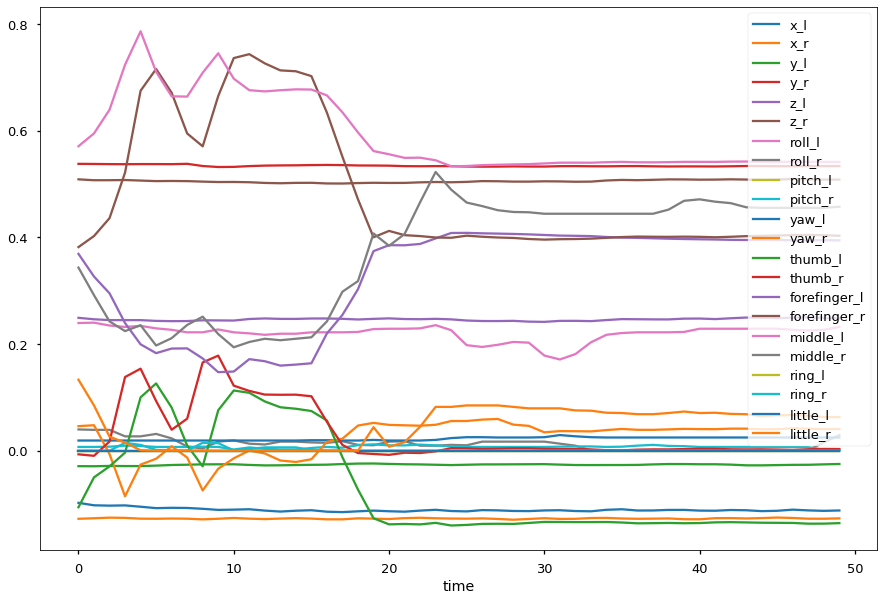

In [ ]:
sign0.plot()

Для каждого из "слов" у нас есть набор показаний сенсоров с разных частей руки в каждый момент времени.

Идея нашего подхода будет заключаться в следующем – давайте для каждого сенсора составим набор характеристик (например, разброс значений, максимальное, минимальное, среднее значение, количество "пиков", и т.п.) и будем использовать эти новые "признаки" для решения задачи классификации.

## Расчет новых признаков

Признаки мы будем считать с помощью библиотеки [tsfresh](http://tsfresh.readthedocs.io/en/latest/index.html). Генерация новых признаков может занять много времени, поэтому мы сохранили посчитанные данные, но при желании вы можете повторить вычисления.

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
## Если не хотите долго ждать - не убирайте комментарии
# !pip install tsfresh


# import tsfresh
# from tsfresh.feature_extraction import extract_features
# from tsfresh.feature_selection import select_features
# from tsfresh.utilities.dataframe_functions import impute
# from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, settings, EfficientFCParameters


# sign_features = extract_features(df_database, column_id='id', column_sort='time',
#                                  default_fc_parameters=EfficientFCParameters(),
#                                  impute_function=impute)

# enc = LabelEncoder()
# enc.fit(sign_classes.loc[:, 'class'])
# sign_classes.loc[:, 'target'] = enc.transform(sign_classes.loc[:, 'class'])

# sign_features_filtered = select_features(sign_features, sign_classes.loc[:, 'target'])

# filepath = './data/tsfresh_features_filt.csv.gz'
# sign_features_filtered.to_csv(filepath, compression='gzip')

In [ ]:
!mkdir ./data
!wget https://www.dropbox.com/s/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz?dl=0 -O ./data/tsfresh_features_filt.csv.gz
filepath = './data/tsfresh_features_filt.csv.gz'
sign_features_filtered = pd.read_csv(filepath)

mkdir: cannot create directory ‘./data’: File exists
--2021-04-10 15:43:53--  https://www.dropbox.com/s/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz [following]
--2021-04-10 15:43:54--  https://www.dropbox.com/s/raw/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc01501d91ac0801e253bdd713a.dl.dropboxusercontent.com/cd/0/inline/BMVVpwE9aTRgLj6jBo0ArN1ojf2NCf3DVZs60sMQdFWCl-yIvaHt4MCTs7fAhnnW8LS0y5O1lg0qnBolP5kK3NZ6jMRUZ5KDpUb45bgllLfmCvMmmX4vIwdyFh0Yt_D4K-wWIuGmStnWsNeQQhTSNM0F/file# [following]
--2021-04-10 15:43:54--  https://ucc01501d91ac0801e253bdd713a.dl.dropboxusercontent.

In [ ]:
sign_features_filtered.shape

(2565, 11517)

In [ ]:
sign_features_filtered.head()

,Unnamed: 0,ring_r__maximum,"ring_r__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""","ring_r__fft_coefficient__attr_""abs""__coeff_2","ring_r__linear_trend__attr_""stderr""",ring_r__quantile__q_0.9,"ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""",ring_r__variance,ring_r__standard_deviation,"ring_r__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","ring_r__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""var""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max""","ring_r__fft_coefficient__attr_""abs""__coeff_1","ring_r__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""max""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""var""","ring_r__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""var""","little_l__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""max""","little_l__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""mean""","little_l__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""var""","ring_r__fft_coefficient__attr_""imag""__coeff_1","ring_r__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.0","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""min""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""mean""","ring_r__linear_trend__attr_""slope""","ring_r__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""var""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""mean""",ring_r__cid_ce__normalize_False,"ring_r__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)","ring_r__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.2","ring_r__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)","ring_r__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)","ring_r__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)","ring_r__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.0","ring_r__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)","ring_r__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""mean""",...,y_r__has_duplicate_max,x_r__large_standard_deviation__r_0.45,x_r__large_standard_deviation__r_0.15000000000000002,yaw_l__symmetry_looking__r_0.25,yaw_l__symmetry_looking__r_0.15000000000000002,roll_r__symmetry_looking__r_0.15000000000000002,roll_r__symmetry_looking__r_0.2,forefinger_r__has_duplicate_min,forefinger_r__symmetry_looking__r_0.05,roll_l__symmetry_looking__r_0.15000000000000002,roll_l__symmetry_looking__r_0.1,forefinger_r__symmetry_looking__r_0.1,forefinger_r__symmetry_looking__r_0.35000000000000003,z_r__large_standard_deviation__r_0.45,forefinger_r__large_standard_deviation__r_0.2,forefinger_r__large_standard_deviation__r_0.45,yaw_r__large_standard_deviation__r_0.4,forefinger_l__has_duplicate_min,thumb_r__large_standard_deviation__r_0.35000000000000003,thumb_r__symmetry_looking__r_0.35000000000000003,thumb_r__symmetry_looking__r_0.30000000000000004,z_r__symmetry_looking__r_0.35000000000000003,forefinger_l__large_standard_deviation__r_0.45,thumb_l__large_standard_deviation__r_0.45,thumb_l__large_standard_deviation__r_0.25,thumb_l__symmetry_looking__r_0.4,thumb_l__symmetry_looking__r_0.1,middle_l__symmetry_looking__r_0.35000000000000003,pitch_l__large_standard_deviation__r_0.45,little_r__symmetry_looking__r_0.2,forefinger_l__large_standard_deviation__r_0.15000000000000002,little_r__symmetry_looking__r_0.15000000000000002,z_l__symmetry_looking__r_0.35000000000000003,roll_r__large_standard_deviation__r_0.25,roll_r__large_standard_deviation__r_0.45,little_r__symmetry_looking__r_0.05,pitch_l__symmetry_looking__r_0.05,z_l__large_stand

## Базовая модель

В результате у нас получилось очень много признаков (11516 или больше), давайте применим метод главных компонент, чтобы получить сжатое признаковое представление, сохранив при этом предиктивную силу в модели.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Создадим бейзлайн без уменьшения размерности. Гиперпараметры модели подбирались произвольно

In [ ]:
# Подготовим данные на вход в модель

# признаки
X = sign_features_filtered.values

# классы
y = sign_classes['class'].values

In [ ]:
# Будем делать кросс-валидацию на 5 фолдов
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')

In [ ]:
base_cv_scores.mean()

0.9196881091617932

## Метод главных компонент (5 баллов)

* (1) Добавьте в пайплайн `base_model` шаг с методом главных компонент. Начиная с версии 0.18 в sklearn добавили разные солверы для PCA. Дополнитенльно задайте в модели следующие параметры: `svd_solder = "randomized"` и `random_state=123`. Остальные гиперпараметры модели и способ кросс-валидации оставьте без изменений
* (1 + 2) Найдите такое наименьшее количество главных компонент, что качество нового пайплайна превыcит 90%. За +2 бала найдите решение не полным перебором
* (1) Укажите долю объяснённой дисперсии при найденной настройке PCA  (для этого надо обучить PCA на всех данных). Долю объясненной диспекрии можно найти в атрибуте `explained_variance_ratio`

In [ ]:
base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(svd_solver='randomized', random_state=123)),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')

In [ ]:
base_cv_scores.mean()

0.9196881091617932

In [ ]:
scaler = StandardScaler()

In [ ]:
X_norm = scaler.fit_transform(X)

In [ ]:
pca = PCA(svd_solver='randomized', random_state=123).fit(X_norm)

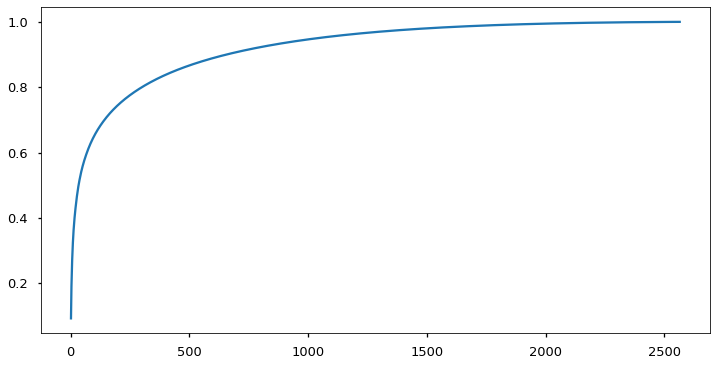

In [ ]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 2566, step=1)
cum_ev = np.cumsum(pca.explained_variance_ratio_)

plt.plot(xi, cum_ev)


plt.show()

In [ ]:
base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=90, svd_solver='randomized', random_state=123)),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')
base_cv_scores.mean()

0.9037037037037038

In [ ]:
base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=86, svd_solver='randomized', random_state=123)),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')
base_cv_scores.mean()

0.8990253411306043

In [ ]:
base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=87, svd_solver='randomized', random_state=123)),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')
base_cv_scores.mean()

0.9005847953216375

Наименьшее количество главных компонент, такое, что качество нового пайплайна превышает 90% - 87

In [ ]:
# Находим долю объяснённой дисперсии для найденной настройки PCA
pca = PCA(n_components=87, svd_solver='randomized', random_state=123).fit(X_)

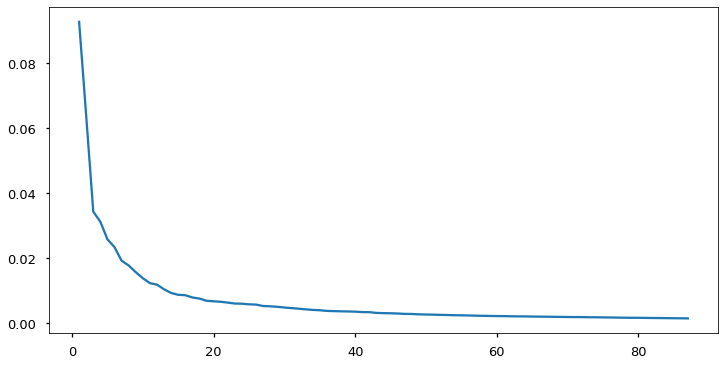

In [ ]:
xi = np.arange(1, 88, step=1)

plt.plot(xi, pca.explained_variance_ratio_)


plt.show()

# Задача про кластеризацию текстов

Рассмотрим коллекцию новостных сообщений за первую половину 2017 года. Про каждое новостное сообщение известны:
* его заголовок и текст
* дата его публикации
* событие, о котором это новостное сообщение написано 
* его рубрика 

In [ ]:
!wget https://raw.githubusercontent.com/vadim0912/MLbase_2021_spring/l4/lecture04/data/news.csv -O ./data/news.csv

--2021-04-11 01:42:57--  https://raw.githubusercontent.com/vadim0912/MLbase_2021_spring/l4/lecture04/data/news.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13352242 (13M) [text/plain]
Saving to: ‘./data/news.csv’

./data/news.csv     100%[===================>]  12.73M  40.7MB/s    in 0.3s    

2021-04-11 01:42:58 (40.7 MB/s) - ‘./data/news.csv’ saved [13352242/13352242]



In [ ]:
df = pd.read_csv('./data/news.csv' 
                 ,encoding='utf8'
                 )
df.head()

,text,date,event,class
0,В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИС...,2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
1,"Lenta.co, Москва, 14 января 2017 СИТУАЦИЯ С П...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
2,"Аргументы и Факты (aif.ru), Москва, 14 января...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
3,"Google Новости ТОП, Москва, 14 января 2017 АК...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
4,"Газета.Ru, Москва, 13 января 2017 В МОСКОВСКО...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ


In [ ]:
df.loc[:, 'class'].value_counts()

Важные мировые события                           403
Внутренняя политика РФ                           364
Внутренняя политика РФ: оппозиция                277
Теракты                                          200
Международные отношения                          153
Спорт                                            102
Спорт                                            100
Проишествия  РФ                                  100
Внутренняя политика: культура                    100
Международные отношения: Криминальная хроника     82
Технологии                                        49
Name: class, dtype: int64

Попробуем кластеризовать документы (каким-либо методом) и сравним полученное разбиение с данными рубликами с помощью ARI

## Стандартная предобработка текстов

Ниже выполняется набор операций по предобработке текстов. Возможно на этом курсе про это не будет идти речь, однако идея довольно простая. Просто следите за комментариями =)

In [ ]:
df.text[0] # Так выглядит первая статья до преобработки

' В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИСААКИЕВСКОГО СОБОРА РПЦ В Санкт-Петербурге люди устроили акцию протеста против передачи Исаакиевского собора в безвозмездное пользование РПЦ. Жители Петербурга собрались на Исаакиевской площади, чтобы высказаться против передачи Исаакиевского собора в безвозмездное пользование РПЦ, передает ТАСС. Акция проходит в формате встречи с депутатами Законодательного собрания города и не требует согласования с властями. Участники акции не используют какую-либо символику и плакаты, а также мегафоны или средства звукоусиления. По словам депутата Алексея Ковалева, на Исаакиевскую площадь пришло примерно тысяча человек. Перед участниками протеста выступили депутаты местного парламента Борис Вишневский и Максим Резник, которые заявили о том, что потребуют отмены решения Смольного. Вишневский сообщил, что акция будет проходить в виде встречи депутатов с избирателями. "Закон Санкт-Петербурга предоставляет нам право встречаться с избирателями, такую встречу

In [ ]:
import re

# Оставляем только кириллические символы
regex = re.compile(u"[А-Яа-я]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))


df.text = df.text.str.lower()
df.loc[:, 'text'] = df.text.apply(words_only)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords

# Удаляем стоп-слова
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', u'также',  'т', 'д', '-', '-']

def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return u" ".join([token for token in text.split() if not token in mystopwords])
    except:
        return u""
    
df.text = df.text.apply(remove_stopwords)   

In [ ]:
!pip install pymystem3
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /root/.local/bin/mystem

--2021-04-11 01:44:39--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.244, 5.45.205.243, 5.45.205.242, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.244|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cache-mskm901.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz [following]
--2021-04-11 01:44:39--  http://cache-mskm901.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving cache-mskm901.cdn.yandex.net (cache-mskm901.cdn.yandex.net)... 5.45.220.11, 2a02:6b8:0:2002::12
Connecting to cache-mskm901.cdn.yandex.net (cache-mskm901.cdn.yandex.net)|5.45.220.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz.2’

mystem-3.0-linux3.1 100%[===================>] 

In [ ]:
%%time 
from pymystem3 import Mystem


# нормализуем текст
# Если закомментить путь, запустить ячейку, прервать, запустить предыдущую, а потом эту, при этом загрузив датасет и сделав всю предобработку заново - всё заработает
m = Mystem(
    '/root/.local/bin/mystem'
    )
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

df.text = df.text.apply(lemmatize)

CPU times: user 3.66 s, sys: 208 ms, total: 3.87 s
Wall time: 27.6 s


In [ ]:
mystoplemmas = [u'который', u'прошлый', u'сей', u'свой', u'наш', u'мочь']

# Еще кое-что удаляем
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

df.text = df.text.apply(remove_stoplemmas)  

In [ ]:
df.text[0] # так выгладит первая статья после предобработки

'петербург проходить митинг против передача исаакиевский собор рпц санкт петербург человек устраивать акция протест против передача исаакиевский собор безвозмездный пользование рпц житель петербург собираться исаакиевский площадь высказываться против передача исаакиевский собор безвозмездный пользование рпц передавать тасс акция проходить формат встреча депутат законодательный собрание город требовать согласование власть участник акция использовать какой либо символика плакат мегафон средство звукоусиление слово депутат алексей ковалев исаакиевский площадь приходить примерно тысяча человек участник протест выступать депутат местный парламент борис вишневский максим резник заявлять потребовать отмена решение смольный вишневский сообщать акция проходить вид встреча депутат избиратель закон санкт петербург предоставлять мы право встречаться избиратель такой встреча проводить рассказывать защищать интерес передача собор сказать парламентарий очередь директор музей исаакиевский собор никола

## Вычисление сходства (1 балл)

С помощью `TfidfVectorizer` и `pairwise_distances` расчитайте **косинусное** расстояние между всеми парами документов к корпусе.

Про векторизацию текстов с помощью `CountVectorizer` или `TfidfVectorizer` можно почитать [тут](https://www.machinelearningmastery.ru/gentle-introduction-bag-words-model/) 

Запишите результат в переменную `S`

In [ ]:
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise

In [ ]:
scaler = StandardScaler()

In [ ]:
vect = TfidfVectorizer()
texts = df.text.values

In [ ]:
X = vect.fit_transform(texts)

In [ ]:
S = pairwise_distances(X, metric='cosine')

[[], []]

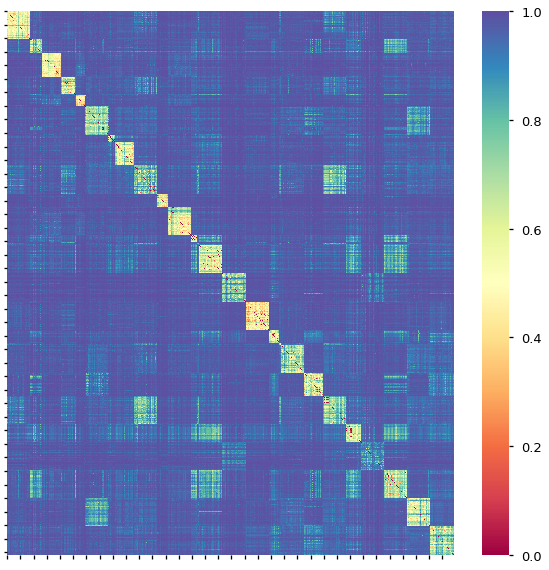

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(data=S, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])


Вы должны пронаблюдать, что между некоторыми текстами есть довольно высокое сходство по содержанию слов - мы видим, что вдоль диагонали матрицы попарых расстояний есть "блоки" по похожести. 

Нам конечно же повезло, так как тексты заранее были удачно упорядочены. В реальности такой живописной картины мы скорее всего не увидим.

Попробуем их кластеризовать

## DBSCAN (4 балла)
* (2) Воспользуйтесь методикой оценки параметров для алгоритма ё. Не копипастите `min_pts = 2` из семинара! Используйте **косинусную** меру близости.
* (1) Выделите кластеры. Для каждого кластера (кроме -1, если он будет) выведите несколько текстов и умозрительно определите его тематику. Можете подсмотреть в исходные тематики корпуса
* (1) Оцените сходство с изначальными рубриками визуально (с помощью матрицы перемешивания) и с помощью [Adjusted Rand Index](https://en.wikipedia.org/wiki/Rand_index)

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

In [ ]:
nn = NearestNeighbors(n_neighbors=40, metric='cosine')

In [ ]:
nn.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=40, p=2,
                 radius=1.0)

In [ ]:
d, idx = nn.kneighbors(X, return_distance=True)

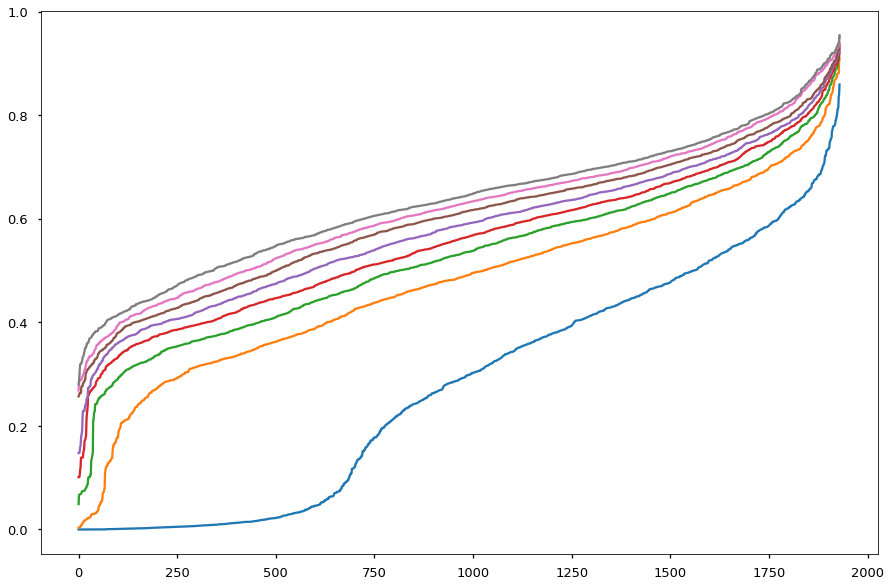

In [ ]:
for i in np.arange(1, 40, 5):
  plt.plot(np.sort(d[:, i]))

In [ ]:
dbscan = DBSCAN(eps=0.67, min_samples=39, metric='cosine')
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.67, leaf_size=30, metric='cosine',
       metric_params=None, min_samples=39, n_jobs=None, p=None)

In [ ]:
labels = dbscan.labels_

In [ ]:
set(labels)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

In [ ]:
df.text[labels==0] # Похоже на "Внутренняя политика РФ"

0     петербург проходить митинг против передача иса...
1     москва январь ситуация передача исаакиевский с...
2     аргумент факт москва январь оппозиция проводит...
3     новость топ москва январь акция против передач...
4     газета москва январь московский патриархия про...
                            ...                        
95    иа политика сегодня москва январь генпрокурату...
96    благовест инфо москва январь союз музей выступ...
97    москва январь инциировать проверка полтавченко...
98    москва январь идиотский решение придумывать не...
99    москва январь исаакиевский собор закрывать ран...
Name: text, Length: 100, dtype: object

In [ ]:
df.text[labels==1] # Я бы сказал, что "Важные мировые события"

100     инаугурация го президент сша дональд трамп пол...
101     москва январь глас соцсеть инаугурация трамп в...
102     москва январь трамп подписывать первый докумен...
103     дэлайт новость москва январь инаугурация трамп...
104     дэлайт новость москва январь инаугурация трамп...
                              ...                        
1725    российский газета москва июль путин принимать ...
1726    москва июль тиллерсон поведывать мешать улучше...
1727    новость москва июль белый дом трамп поверять п...
1728    москва июль трамп давать комментарий повод сод...
1729    москва июль трамп сообщать приходить время кон...
Name: text, Length: 396, dtype: object

In [ ]:
df.text[labels==2] # "Важные мировые события"

151    умирать виталий чуркин постоянный представител...
152    москва февраль москвич нести цветок здание мид...
153    москва февраль путин посмертно награждать чурк...
154    москва февраль москвич нести цветок здание мид...
155    москва февраль неожиданный смерть мид рф сложн...
                             ...                        
230    москва февраль умирать виталий чуркин причина ...
231    взгляд ру москва февраль умирать виталий чурки...
232    дэлайт новость москва февраль умирать виталий ...
233    москва февраль путин выражать соболезнование б...
234    москва февраль виталий чуркин причина смерть б...
Name: text, Length: 84, dtype: object

In [ ]:
df.text[labels==3]  # "Внутренняя политика РФ: оппозиция"

235    кроссовок медведева тяжелый артиллерия правда ...
236    москва март кремль прокомментировать расследов...
237    москва март фонд борьба коррупция фбк алексей ...
238    москва март фбк расследование медведев собират...
239    москва март фбк расследование медведев собират...
                             ...                        
292    москва март фбк обнародоваться результат рассл...
293    афиша москва март алексей навальный выпускать ...
294    москва март навальный обвинять медведев создан...
295    русский монитор москва март навальный доказыва...
296    русский монитор москва март навальный доказыва...
Name: text, Length: 62, dtype: object

In [ ]:
df.text[labels==4] # "Международные отношения: Криминальная хроника"

299    восемь сердце рокфеллер скончаться миллиардер ...
300    геополитика москва март умирать дэвид рокфелле...
301    москва март умирать дэвид рокфеллер факт жизнь...
302    сми москва март м год жизнь умирать старый мил...
303    москва март умирать дэвид рокфеллер миллиардер...
304    экоград москва март умирать дэвид рокфеллер ми...
305    иа объединять европа москва март м год жизнь у...
306    ади москва март умирать дэвид рокфеллер америк...
307    президент москва март эхо публикация мертвый р...
308    новость топ москва март умирать дэвид рокфелле...
309    москва март дэвид рокфеллер умирать причина фо...
310    москва март умирать дэвид рокфеллер старый мил...
311    теория дискредитация москва март великий ужасн...
312    москва март восемь сердце рокфеллер дэвид рокф...
313    москва март великий ужасный умирать дэвид рокф...
314    москва март дэвид рокфеллер умирать причина фо...
315    москва март дэвид рокфеллер умирать причина фо...
316    москва март восемь сердц

In [ ]:
df.text[labels==5] # "Теракты"

340     сми ошибочно называть исполнитель теракт лондо...
341     яндекс новость москва март число погибший резу...
342     яндекс новость москва март число погибший резу...
343     новость день москва март теракт лондон март гл...
344     москва март устраивать теракт лондон бородач и...
                              ...                        
1825    риа новость москва август человек нести цветок...
1826    риа новость москва август житель барселона зна...
1827    риа новость москва август испания время теракт...
1828    риа новость москва август эксперт сожаление бе...
1829    риа новость москва август мвд германия исключа...
Name: text, Length: 194, dtype: object

In [ ]:
df.text[labels==6] # Международные отношения: Криминальная хроника

467    упор рикошет автор польгуев екатерина выстрел ...
468    новость москва март украинский сми убийца воро...
469    империя москва март украинский сми убийца воро...
470    взгляд ру москва март украинский сми убийца во...
471    русый инфо москва март киев застреливать бывши...
                             ...                        
544    утро москва март смерть вороненков предсказыва...
545    утро москва март киев убивать денис вороненков...
546    москва март киев убивать денис вороненков киев...
547    новость москва март центр киев убивать денис в...
548    политроссия москва март смерть вороненков пред...
Name: text, Length: 82, dtype: object

In [ ]:
df.text[labels==7] # "Внутренняя политика РФ: оппозиция"

549     развилка кремль реагировать протест весь росси...
550     московский комсомолец москва март бухгалтерия ...
551     ведомость москва март участник несанкционирова...
552     москва март песок подросток обещать валютный н...
553     москва март димон выходить вон подростковый во...
                              ...                        
1463    москва июнь эксперт прокомментировать акция пр...
1464    политика москва июнь навальный арестовывать ме...
1465    москва июнь российский протест потенциал арест...
1466    газета москва июнь пропустить концерт е зато ч...
1467    москва июнь российский оппозиционер навальный ...
Name: text, Length: 161, dtype: object

In [ ]:
df.text[labels==8] # "Технологии"

649    рогозин поздравлять илона маска удачный запуск...
650    яндекс новость москва март проводить повторный...
651    яндекс новость москва март рогозин поздравлять...
652    москва март производить ый история повторный з...
653    серебряный дождь москва март дмитрий рогозин п...
654    тк звезда москва март рогозин поздравлять маск...
655    рбк москва март рогозин поздравлять илона маск...
656    москва март рогозин поздравлять илона маска по...
657    тасс единый лента закрывать лента москва март ...
658    москва март размещать видео неповторимый повто...
659    москва март песок рассказывать многоразовый ра...
660    москва март осуществлять ый повторный запуск р...
661    москва марта сообщать успешный приземление гол...
662    москва марта сообщать успешный приземление гол...
663    тасс единый лента закрывать лента москва март ...
664    москва март песок роскосмос достойно конкуриро...
665    правда ру москва март прорыв шоу запускать пос...
666    москва март осуществлять

In [ ]:
df.text[labels==9] # "Внутренняя политика: культура"

698    поэт автор яхонтов андрей умирать евгений евту...
699    москва апрель евгений евтушенко рок звезда сов...
700    известие москва апрель современник запоминать ...
701    москва апрель умирать евгений евтушенко вдова ...
702    москва апрель максим галкин выкладывать поклон...
                             ...                        
793    радио свобода москва апрель евтушенко конец от...
794    российский газета москва апрель умирать евгени...
795    москва апрель сша умирать евгений евтушенко сш...
796    москва апрель умирать евгений евтушенко сообща...
797    новый известие москва апрель умирать евгений е...
Name: text, Length: 99, dtype: object

In [ ]:
df.text[labels==10] # "Спорт"

931     тасс москва май команда россия сша разыгрывать...
932     риа новость москва май выходить плей офф сборн...
933     известие москва май кельн медаль автор алексей...
934     тасс москва май очередной испытание команда зн...
935     тасс москва май плохой лед золушка латвия чм х...
                              ...                        
1026    известие москва май кузнецов орел хороший усил...
1027    московский комсомолец москва май стартовый гал...
1031    чемпионат москва май коста тащить франция навс...
1032    российский газета москва май андрей василевски...
1530    коммерсант москва июнь приключение чемпион рос...
Name: text, Length: 83, dtype: object

In [ ]:
df.text[labels==11] # "Внутренняя политика РФ"

1033    турист скидываться рубль крым автор фаляхов ру...
1034    яндекс новость москва май дума вносить законоп...
1035    москва май правительство вносить госдума закон...
1036    москва май госдума вносить законопроект курорт...
1037    москва май госдума вносить законопроект курорт...
                              ...                        
1128    москва май курортный сбор пойти развитие курор...
1129    труд москва май госдума вносить законопроект к...
1130    москва май правительство вносить госдума закон...
1131    новость москва май госдума вносить законопроек...
1132    москва май правительство вносить госдума закон...
Name: text, Length: 100, dtype: object

In [ ]:
df.text[labels==12] # "Важные мировые события"

1133    сми прогнозировать столкновение макрон трамп п...
1134    москва май макрон побеждать президентский выбо...
1135    москва май юнкер заявлять счастливый работать ...
1136    новость москва май юнкер заявлять счастливый р...
1137    риа новость москва май юнкер заявлять счастлив...
1138    москва май сми прогнозировать столкновение мак...
1139    москва май сми считать столкновение макрон тра...
1140    москва май победа макрон ожидать событие поэто...
1141    москва май сми прогнозировать столкновение мак...
1142    москва май сми прогнозировать столкновение мак...
1143    москва май сми прогнозировать столкновение мак...
1144    тв центр москва май путин поздравлять макрон п...
1145    сми москва май президентский выборы франция по...
1146    москва май макрон побеждать президентский выбо...
1147    иа объединять европа москва май президентский ...
1148    тасс единый лента закрывать лента москва май т...
1149    правдинформ москва май быть защищать европа ма...
1151    инстит

In [ ]:
df.text[labels==13] # "Происшествия РФ"

1186    жертва ураган москва список компенсация ураган...
1187    институт религия политика москва май результат...
1188    москва май увеличиваться количество пострадавш...
1189    поливать грамота москва май жертва ураган моск...
1190    москва май ск рф сообщать новый сведение погиб...
                              ...                        
1281    национальный служба новость москва май ликвида...
1282    московский комсомолец москва май собянин семья...
1283    москва май патриарх кирилл помолиться жертва у...
1284    москва май компенсация пострадать ураган число...
1285    москва май последствие ураган москва быть ликв...
Name: text, Length: 99, dtype: object

In [ ]:
df.text[labels==14] # "Внутренняя политика РФ"

1830    выборы сюрприз эксперт называть явка единый де...
1831    коммерсант москва сентябрь единообразный день ...
1832    риа новость москва сентябрь явка выборы москва...
1833    риа новость москва сентябрь единый день голосо...
1834    риа новость москва сентябрь россиянин выбирать...
                              ...                        
1925    москва сентябрь кандидат депутат москва покуса...
1926    москва сентябрь избирком оценивать явка выборы...
1927    москва сентябрь кандидат столичный депутат пож...
1928    москва сентябрь медведев припоминать избранный...
1929    москва сентябрь жириновский призывать перенест...
Name: text, Length: 96, dtype: object

In [ ]:
np.sum(labels==-1)

241

In [ ]:
pd.crosstab(df.loc[:, 'class'], labels)

col_0,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
class,,,,,,,,,,,,,,,,
Важные мировые события,10,0,225,84,0,41,0,0,0,0,0,0,0,43,0,0
Внутренняя политика РФ,6,100,62,0,0,0,0,0,0,0,0,0,100,0,0,96
Внутренняя политика РФ: оппозиция,53,0,1,0,62,0,0,0,161,0,0,0,0,0,0,0
Внутренняя политика: культура,1,0,0,0,0,0,0,0,0,0,99,0,0,0,0,0
Международные отношения,47,0,106,0,0,0,0,0,0,0,0,0,0,0,0,0
Международные отношения: Криминальная хроника,0,0,0,0,0,0,0,82,0,0,0,0,0,0,0,0
Проишествия РФ,1,0,0,0,0,0,0,0,0,0,0,0,0,0,99,0
Спорт,99,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Спорт,20,0,0,0,0,0,0,0,0,0,0,82,0,0,0,0


In [ ]:
from sklearn.metrics import adjusted_rand_score

In [ ]:
true_label = LabelEncoder().fit_transform(df.loc[:, 'class'])

In [ ]:
adjusted_rand_score(true_label, labels)

0.4708894431842465

In [ ]:
def dbscan_grid_search(X_data, lst, score, eps_space = 0.5,
                       min_samples_space = 5):

    # Starting a tally of total iterations
    n_iterations = 0


    # Looping over each combination of hyperparameters
    for eps_val in eps_space:
        for samples_val in min_samples_space:

            dbscan_grid = DBSCAN(eps = eps_val,
                                 min_samples = samples_val,
                                 metric='cosine')


            # fit
            labels = dbscan_grid.fit(X = X_data)

            # Increasing the iteration tally with each run of the loop
            n_iterations += 1

            dbscan_clusters.append([eps_val,
                                    samples_val])


            # clst_count.append(cluster_count)

            score.append(adjusted_rand_score(true_label, dbscan_grid.labels_))

    # Printing grid search summary information
    print(f"""Search Complete. \nYour list is now of length {len(lst)}. """)
    print(f"""Hyperparameter combinations checked: {n_iterations}. \n""")

In [ ]:
dbscan_clusters = []
cluster_count   = []
adjr_score = []
dbscan_grid_search(X_data = X,
                   lst = dbscan_clusters,
                   score = adjr_score,
                   eps_space = np.arange(0.6, 0.8, 0.01),
                   min_samples_space =np.arange(35, 50, 1))

Search Complete. 
Your list is now of length 315. 
Hyperparameter combinations checked: 315. 



In [ ]:
print(max(adjr_score), dbscan_clusters[np.argmax(adjr_score)])

0.4708894431842465 [0.67, 39]
